# 05. Обучение CNN

## План
1. CIFAR10: baseline
2. Просто добавим аугментаций
3. Pretrained vs from scratch
4. LR scheduling

[Отчёт в Wandb по семинару появится после семинара](https://api.wandb.ai/links/dondo_sss/alksqdii)

### 0. Ключ wandb

In [ ]:
! pip install wandb -q

In [ ]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
%config InlineBackend.figure_format='retina'

## 1. CIFAR10: baseline

Мы уже умеем составлять несложные архитектуры нейросетей и обучать их на произвольных (картиночных) датасетах.
На этом семинаре мы поговорим о том, какие ручки можно покрутить, чтобы улучшать результаты.

Перечислим некоторые (но точно не все) из таких ручек:

* Параметры модели
  * тип архитектуры
    * семейство (ResNet / EfficientNet / ...)
    * размер модели (ResNet18 / ResNet101?)
  * число обучаемых слоёв
    * warmup при дообучении
  * ...

* Параметры оптимизации
  * собственно оптимизатор (SGD / Adam + вариации / ...)
  * learning rate
    * scheduling
  * momentum
  * weight decay
  * ...
  
* Параметры данных
  * веса классов / сэмплирование
  * набор и сила аугментаций
  * чистка
  * ...

* Параметры обучения
  * размер батча
  * функция потерь
  * целевая метрика (да, не `val_loss`-ом единым)  
  * критерий остановки
  * ...
  
* ...


Но решение любой задачи начинается с построения бейзлайна!

### 1.1. Получаем данные

In [ ]:
import os
import glob
import pickle
import tqdm
import cv2
from torchvision.datasets import CIFAR10

### 1.2. Собираем датасет и знакомимся с данными

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

Прежде мы при обращении к картинкам через датасет обрабатывали их руками (конвертировали в тензор, например).
Можно (и вообще говоря нужно) делать это через механизм трансформаций:

In [ ]:
transforms_simple = T.Compose(
    [
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25])
    ]  # по-хорошему нужно брать из датасета
)
# normalized_tensor = (tensor - mean) / std

Здесь мы использовали для трансформаций модуль `torhvision.transforms`, но есть и альтернативы (о них чуть ниже).
Пока что мы ограничились включением в трансформации только базовых операций - конвертации в тензор и нормализации.

In [ ]:
dataset_train = CIFAR10("./", train=True, download=True, transform=transforms_simple)

100%|██████████| 170498071/170498071 [00:03<00:00, 43617678.75it/s]


Extracting ./cifar-10-python.tar.gz to ./


In [ ]:
image, label = dataset_train[0]
image.shape, label

(torch.Size([3, 32, 32]), 6)

In [ ]:
cifar10_class_map = {idx: idx_class for idx_class, idx in dataset_train.class_to_idx.items()}
cifar10_class_map

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

Для обратной конвертации в картинку (чтобы отрисовать ее, например), нужно сделать "де-нормализацию":

**Задача**: реализовать функцию `tensor_to_image`, получающую на вход нормализованный тензор `(3, h, w)`, возвращающую де-нормализованный массив `(h, w, 3)`.

In [ ]:
def tensor_to_image(tensor, mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)):
    ### YOUR CODE HERE

    # mean, std -> ...
    # h,w,c -> c,h,w
    mean_tensor = torch.tensor(mean)[None, None, :]
    std_tensor = torch.tensor(std)[None, None, :]

    ### END OF YOUR CODE
    image = tensor.permute(1,2,0) * std_tensor + mean_tensor

    return image

In [ ]:
image = np.random.uniform(size=(32, 32, 3))
tensor = (torch.from_numpy(image).permute(2, 0, 1) - 0.5) / 0.25

np.testing.assert_array_equal(image, tensor_to_image(tensor))

Посмотрим глазами на данные:

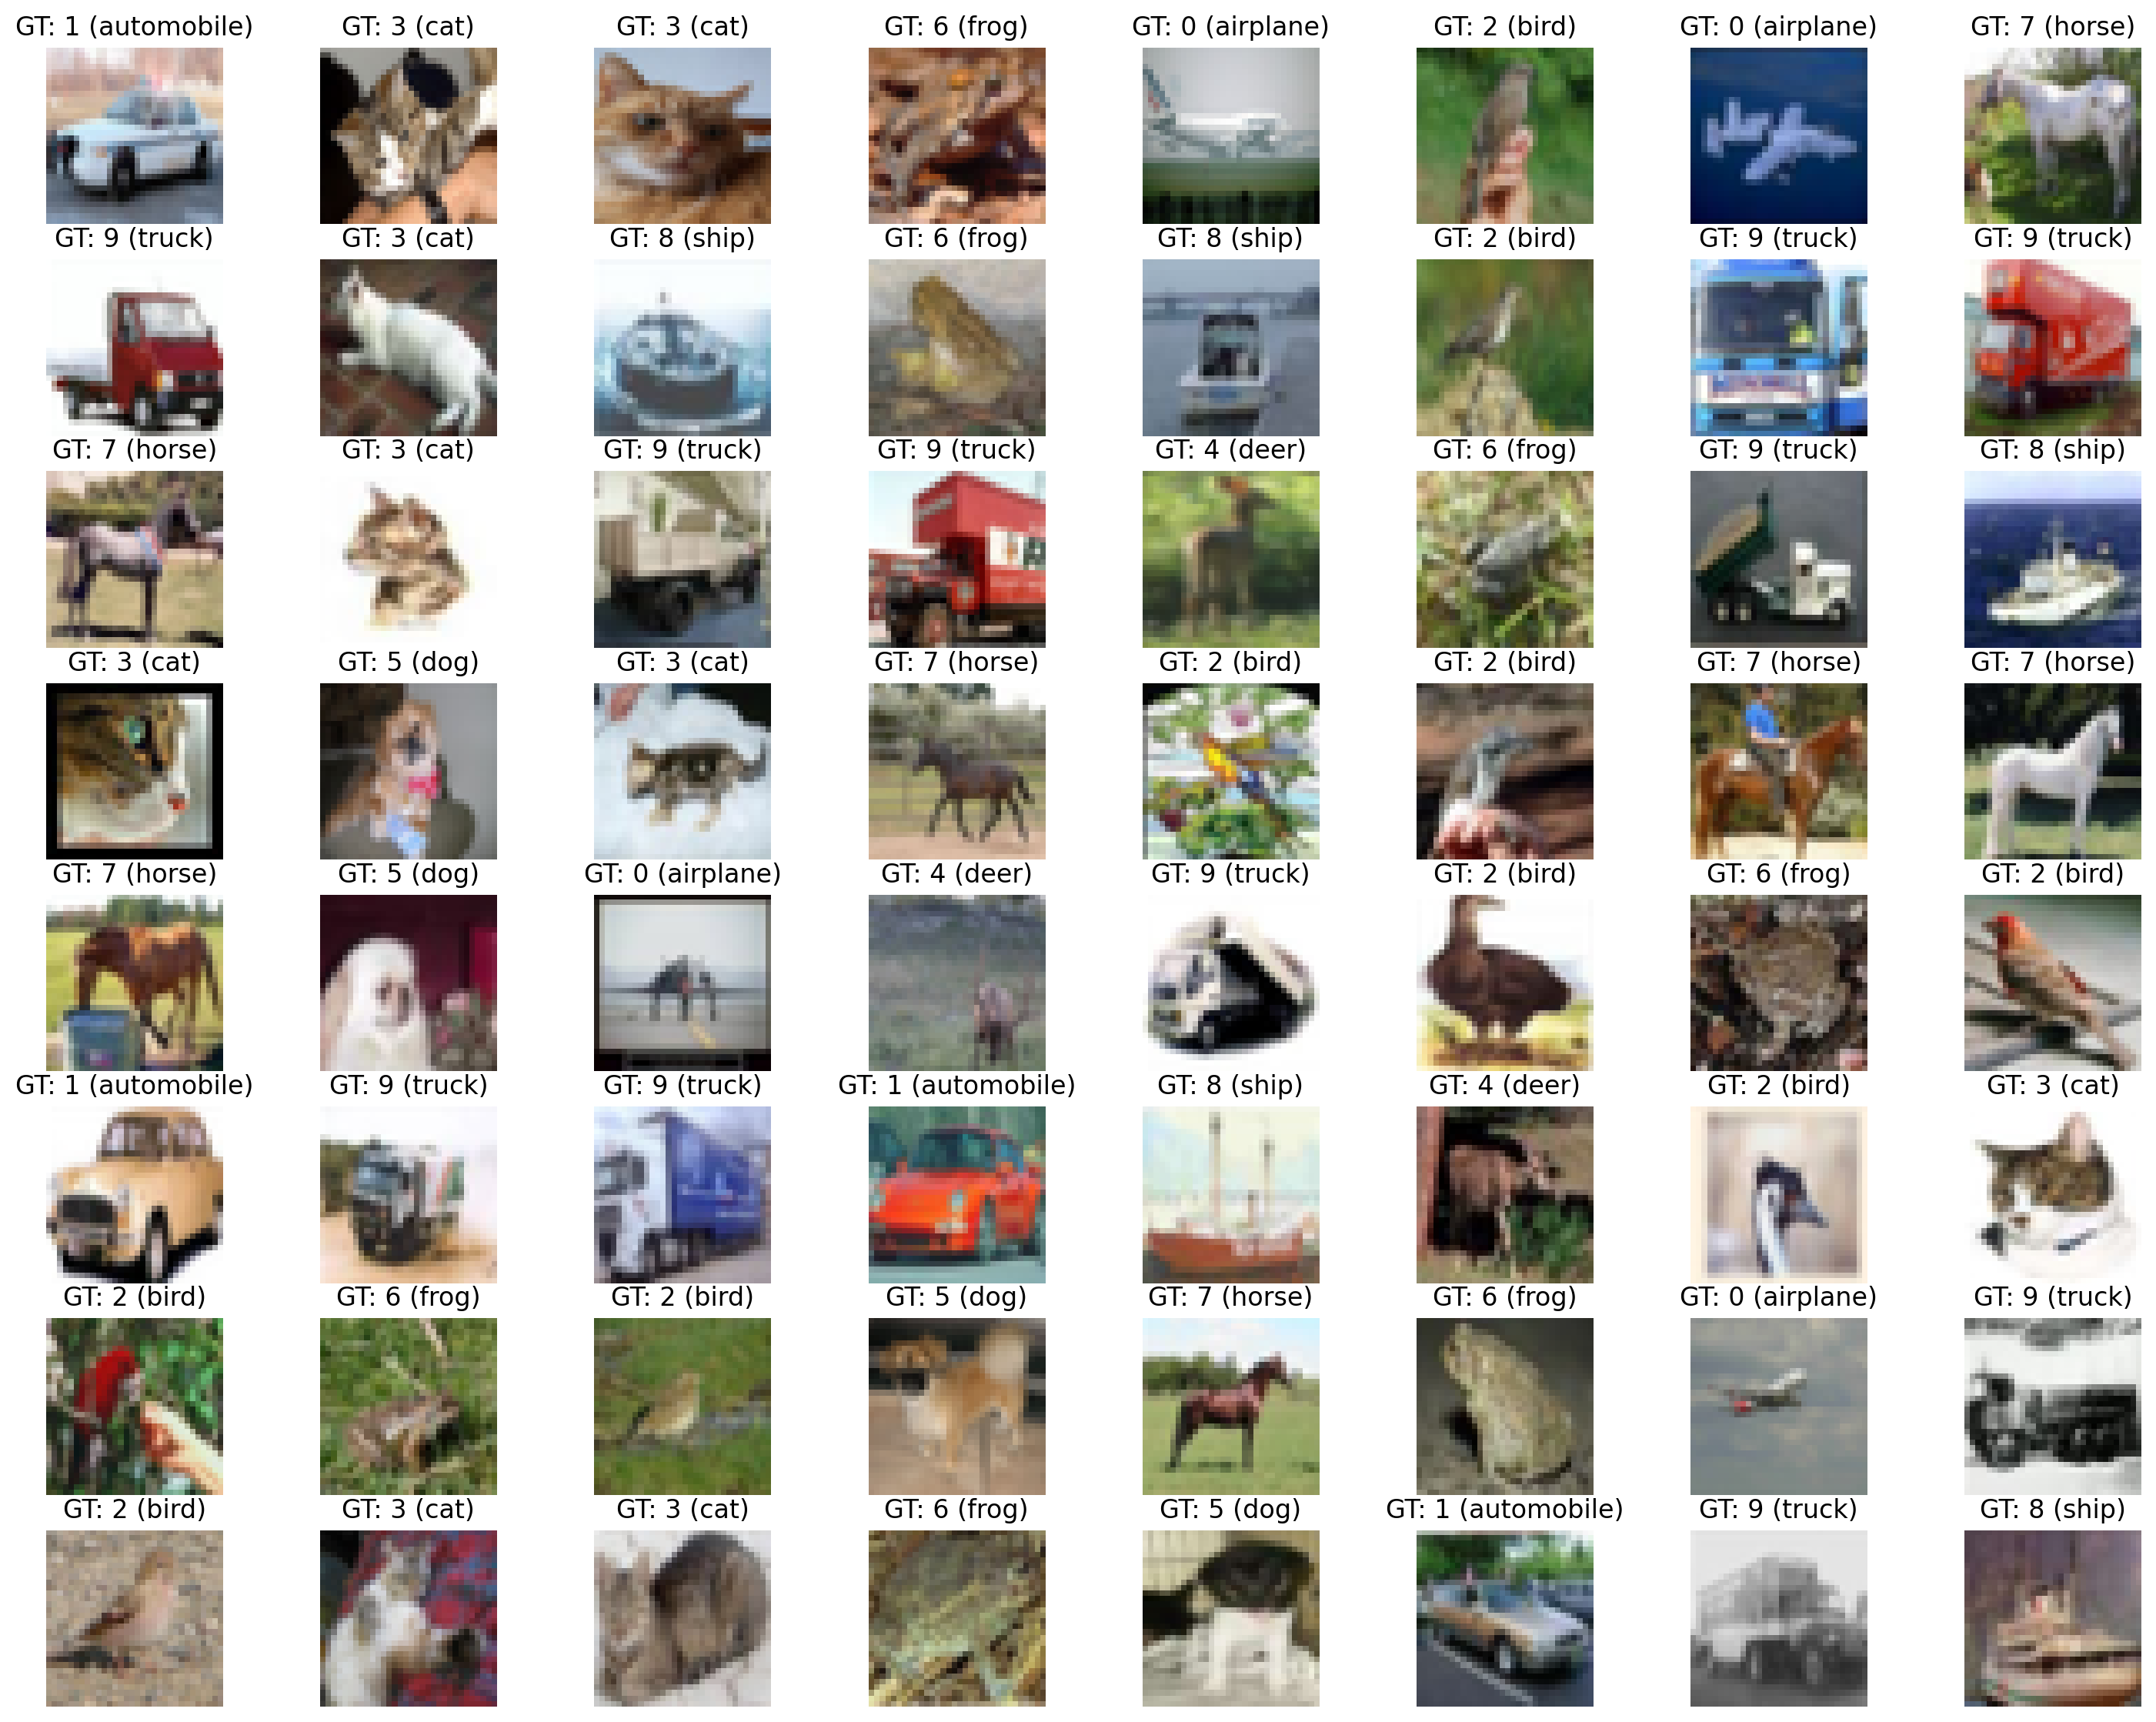

In [ ]:
indexes_to_show = np.random.choice(len(dataset_train), size=64, replace=False)

plt.figure(figsize=(18, 14))
for i, index in enumerate(indexes_to_show):
    tensor, label = dataset_train[index]
    image = tensor_to_image(tensor)
    plt.subplot(8, 8, i + 1)
    plt.imshow(image)
    plt.axis(False)
    plt.title(f"GT: {label} ({cifar10_class_map[label]})")
plt.show()

Обычно полезно провести разведывательный анализ данных (EDA).
Сейчас ограничимся тем, что посмотрим на распределение количества картинок по классам.

**Задача**: любым удобным способ вывести количество изображений по каждому классу в обучающем датасете.

In [ ]:
labels_train = np.array([label for _, label in dataset_train])

In [ ]:
### YOUR CODE HERE
np.unique(labels_train, return_counts=True)
### END OF YOUR CODE

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

Не забудем собрать валидационный датасет, и двинемся дальше:

In [ ]:
dataset_val = CIFAR10("./", train=False, download=False, transform=transforms_simple)

In [ ]:
labels_val = np.array([label for _, label in dataset_val])

In [ ]:
### YOUR CODE HERE
np.unique(labels_val, return_counts=True)
### END OF YOUR CODE

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

### 1.3. Собираем модель

Начнем, как и собирались, с бейзлайна.
Бейзлайн - это какое-то простое решение, которые конкретно вы можете быстро реализовать и проверить.
Чуть позже бейзлайном вы будете считать уже ResNet34, но пока напишем его ручками.

conv -> bn -> relu -> conv -> bn -> relu (pool)

**Задание**: реализуйте метод для инициализации блока сверточной сети. Блок должен работать так:
* conv 3x3 / in_channels -> out_channels
* batchnorm2d
* relu
* conv 3x3
* batchnorm2d
* relu
* (optionally) maxpool 2x2

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool=True):
        super(CNNBlock, self).__init__()

        ### YOUR CODE HERE
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.maxpool= nn.MaxPool2d((2, 2)) if pool else nn.Identity()
        ### END OF YOUR CODE

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x

Соберем из этих блоков сеть:

In [ ]:
cnn_baseline = nn.Sequential(
    CNNBlock(3, 32),
    CNNBlock(32, 64),
    CNNBlock(64, 128),
    CNNBlock(128, 256),
    CNNBlock(256, 512),
    # v NOTE THIS
    nn.AdaptiveAvgPool2d((1, 1)),  # B x 512 x 1 x 1
    # ^ NOTE THIS ^
    nn.Flatten(),  # B x 512
    nn.Linear(512, 10),
).eval()

In [ ]:
x = torch.randn(4, 3, 32, 32)
y = cnn_baseline(x)
y.shape

torch.Size([4, 10])

### 1.4. Учим
#### 1.4.1 Логгирование на примере Wandb

In [ ]:
len(dataset_train)

50000

In [ ]:
import wandb

config = {
    "learning_rate": 3e-4,
    "weight_decay": 0.01,
    "batch_size": 50,
    "num_epochs": 5,
    "optimizer": torch.optim.AdamW,
}

wandb.init(
    # set the wandb project where this run will be logged
    project="seminar-05-cnn-2024",
    name="baseline",
    reinit=True,
    # track hyperparameters and run metadata
    config=config,
)

wandb: Currently logged in as: dondo_sss. Use `wandb login --relogin` to force relogin


In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [ ]:
import os

num_workers = os.cpu_count()
num_workers

2

In [ ]:
dataloader_train = DataLoader(
    dataset_train,
    batch_size=config["batch_size"],
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=4,
)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=config["batch_size"],
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=4,
)

Инициализируйте сами необходимый лосс и оптимизатор Adam, взяв готовые из `pytorch`:

In [ ]:
config

{'learning_rate': 0.0003,
 'weight_decay': 0.01,
 'batch_size': 50,
 'num_epochs': 5,
 'optimizer': torch.optim.adamw.AdamW}

In [ ]:
### YOUR CODE HERE

# loss_fn = ...
# optimizer = ...
loss_fn = nn.CrossEntropyLoss()
optimizer = config['optimizer'](cnn_baseline.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

### END OF YOUR CODE

Раньше у нас были отдельные методы для обучения/валидации - теперь мы готовы сделать из них один:

In [ ]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, epoch, device):
    # v NOTE THIS v
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()
    # ^ NOTE THIS ^

    model = model.to(device)
    num_steps = len(dataloader)
    losses = []
    for i, batch in enumerate(tqdm.tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}")):
        xs, ys_true = batch

        ys_pred = model(xs.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        if stage == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # логгируем номер шага при обучении
            wandb.log({
                "training_step": i + num_steps * epoch,
                "lr": optimizer.param_groups[0]["lr"],
                "loss": loss,
            })

        losses.append(loss.detach().cpu().item())

    return np.mean(losses)

При вызове `wandb.log` каждый раз обновлется внутренний счётчик шагов логгера, не связанный с номером итерации во время обучения или валидации, поэтому целесообразно вместе с значениями лоссов и метрик записывать шаг обучения/номер эпохи для корректного сравнения разных величин.

Кроме того, мы готовы к чему-то большему, чем просто брать последний чекпоинт модели.
Будем контролировать значение целевой метрики (сегодня это `val_loss`), и сохранять чекпоинт модели в случае, если он лучший.

In [ ]:
def save_checkpoint(model, filename):
    with open(filename, "wb") as fp:
        torch.save(model.state_dict(), fp)

def load_checkpoint(model, filename):
    with open(filename, "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(state_dict)

In [ ]:
my_model = nn.Linear(100, 1)
my_model.weight.data *= 1e6
save_checkpoint(my_model, "test.pth.tar")

my_model_new = nn.Linear(100, 1)
load_checkpoint(my_model_new, "test.pth.tar")

torch.testing.assert_allclose(my_model.weight, my_model_new.weight)

<ipython-input-29-db9d1f5d0be5>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(fp, map_location="cpu")
<ipython-input-30-20449b098a83>:8: FutureWar

Экспериментов у нас будет много, поэтому для экономии кода обернем все, что нужно для обучения, в функцию `run_experiment()`:

In [117]:
def run_experiment(
    model, dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, output_dir, start_epoch=0
):
    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    best_val_loss_epoch = -1
    best_val_loss_fn = None

    os.makedirs(output_dir, exist_ok=True)

    for epoch in range(start_epoch, num_epochs):
        train_loss = run_epoch("train", model, dataloader_train, loss_fn, optimizer, epoch, device)
        train_losses.append(train_loss)

        val_loss = run_epoch("val", model, dataloader_val, loss_fn, optimizer, epoch, device)
        val_losses.append(val_loss)

        wandb.log({"epoch_loss_train": train_loss, "epoch_loss_val": val_loss, "epoch": epoch})

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_loss_epoch = epoch

            output_fn = os.path.join(output_dir, f"epoch={str(epoch).zfill(2)}_valloss={best_val_loss:.3f}.pth.tar")
            save_checkpoint(model, output_fn)
            print(f"New checkpoint saved to {output_fn}\n")

            best_val_loss_fn = output_fn

    print(f"Best val_loss = {best_val_loss:.3f} reached at epoch {best_val_loss_epoch}")
    load_checkpoint(model, best_val_loss_fn)

    return train_losses, val_losses, best_val_loss, model

Запустим:

In [ ]:
train_losses_baseline, val_losses_baseline, best_val_loss_baseline, cnn_baseline = run_experiment(
    cnn_baseline,
    dataloader_train,
    dataloader_val,
    loss_fn,
    optimizer,
    config["num_epochs"],
    device,
    "checkpoints_baseline",
)

epoch: 000 | train: 100%|██████████| 1000/1000 [00:24<00:00, 41.30it/s]
epoch: 000 | val  : 100%|██████████| 200/200 [00:02<00:00, 69.13it/s]


New checkpoint saved to checkpoints_baseline/epoch=00_valloss=0.841.pth.tar



epoch: 001 | train: 100%|██████████| 1000/1000 [00:23<00:00, 41.91it/s]
epoch: 001 | val  : 100%|██████████| 200/200 [00:02<00:00, 68.66it/s]


New checkpoint saved to checkpoints_baseline/epoch=01_valloss=0.670.pth.tar



epoch: 002 | train: 100%|██████████| 1000/1000 [00:22<00:00, 43.60it/s]
epoch: 002 | val  : 100%|██████████| 200/200 [00:05<00:00, 39.82it/s]
epoch: 003 | train: 100%|██████████| 1000/1000 [00:22<00:00, 44.10it/s]
epoch: 003 | val  : 100%|██████████| 200/200 [00:03<00:00, 64.26it/s]
epoch: 004 | train: 100%|██████████| 1000/1000 [00:24<00:00, 40.11it/s]
epoch: 004 | val  : 100%|██████████| 200/200 [00:02<00:00, 67.84it/s]

New checkpoint saved to checkpoints_baseline/epoch=04_valloss=0.650.pth.tar

Best val_loss = 0.650 reached at epoch 4



<ipython-input-29-db9d1f5d0be5>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(fp, map_location="cpu")


In [ ]:
wandb.finish()

epoch,▁▃▅▆█
epoch_loss_train,█▄▃▂▁
epoch_loss_val,█▃▂▁▁
loss,█▇█▄▅▃▃▃▄▄▄▅▂▄▂▁▂▃▂▃▃▁▂▁▂▃▂▂▃▃▁▂▁▁▂▁▂▂▂▂
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,4
epoch_loss_train,0.34794
epoch_loss_val,0.64109
loss,0.32153
lr,0.0003


Смотрим результаты:

In [ ]:
def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(12, 5))
    plt.title(title)
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True)
    plt.legend()
    plt.show()

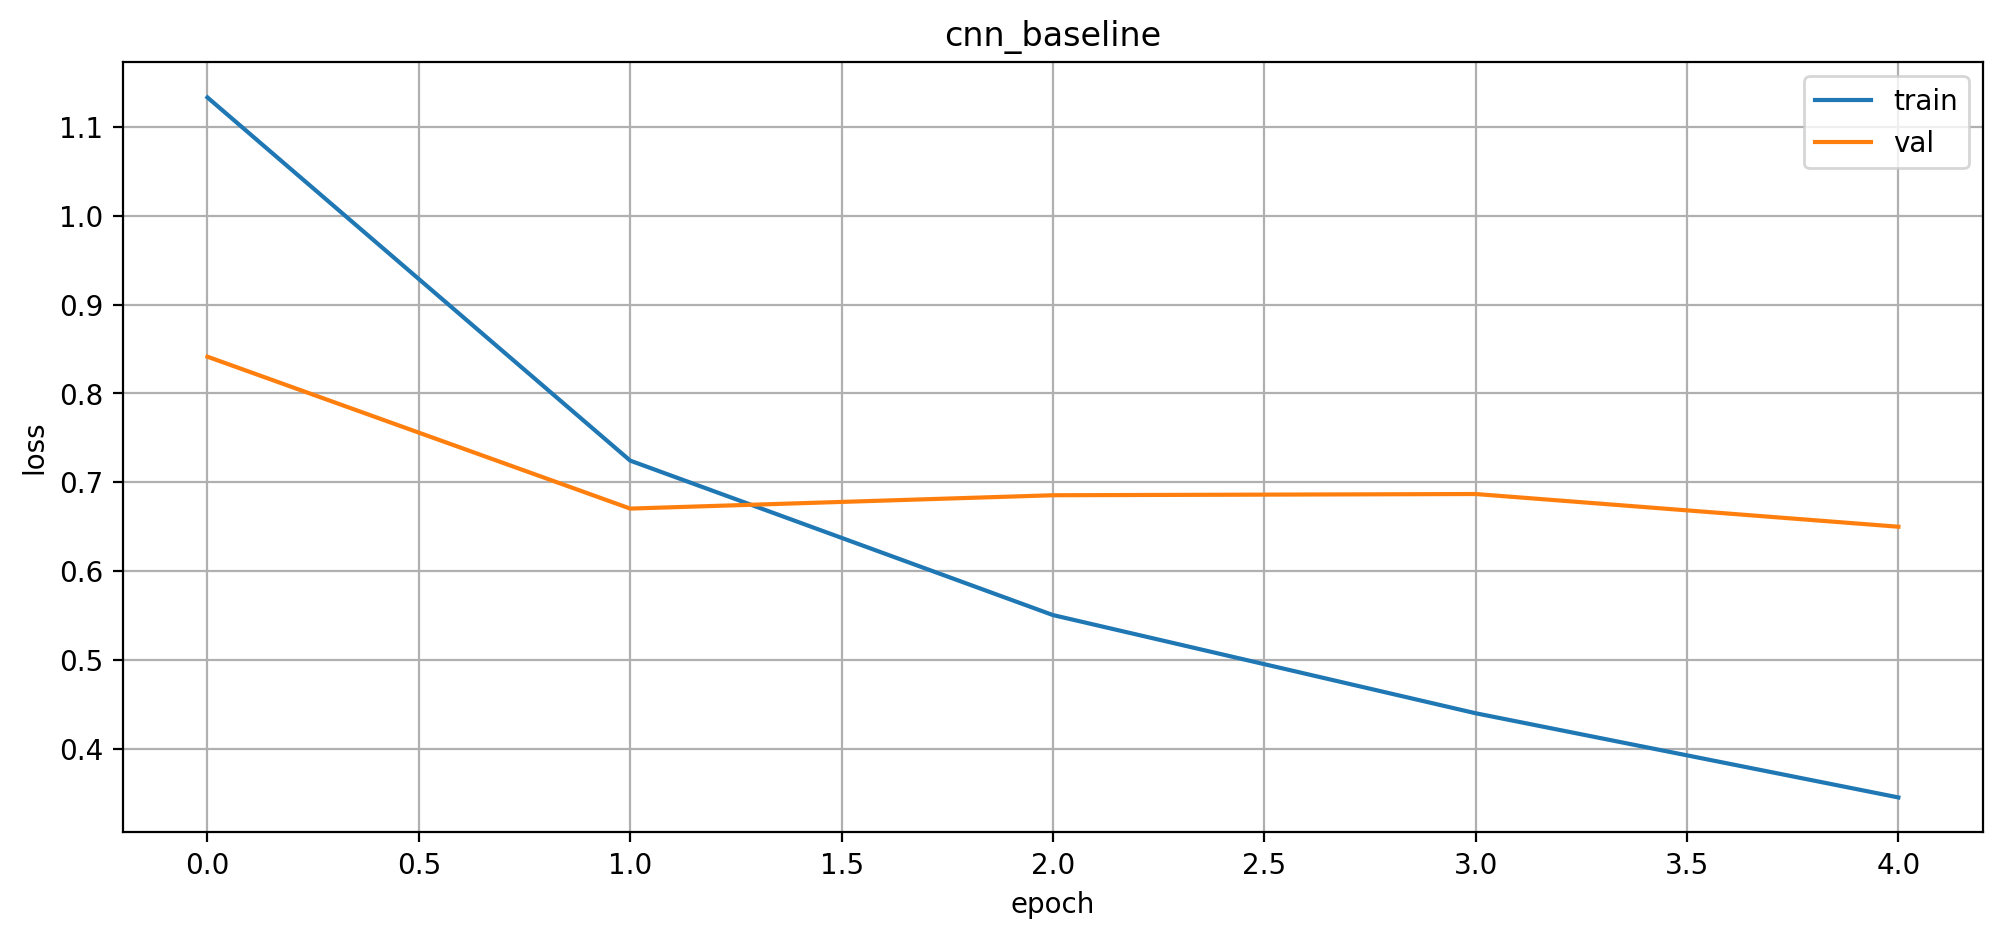

In [ ]:
plot_losses(train_losses_baseline, val_losses_baseline, title="cnn_baseline")

Считаем метрики:

In [ ]:
def collect_predictions(model, dataloader, device):
    model.eval()
    model = model.to(device)
    torch.set_grad_enabled(False)

    labels_all = []
    probs_all = []
    preds_all = []
    for batch in tqdm.tqdm(dataloader, total=len(dataloader)):
        images, labels = batch

        logits = model(images.to(device))
        # softmax вычислительно неэффективен, поэтому не стоит лишний раз им пользоваться
        # probs = logits.softmax(dim=1)
        probs = logits.to(device="cpu")
        max_prob, max_prob_index = torch.max(probs, dim=1)

        labels_all.extend(labels.numpy().tolist())
        probs_all.extend(max_prob.numpy().tolist())
        preds_all.extend(max_prob_index.numpy().tolist())

    return labels_all, probs_all, preds_all

In [ ]:
train_labels, train_probs, train_preds = collect_predictions(cnn_baseline, dataloader_train, device)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

100%|██████████| 1000/1000 [00:21<00:00, 45.86it/s]


0.9063

In [ ]:
train_labels[:5], train_preds[:5], train_probs[:5]

([3, 1, 8, 9, 0],
 [3, 1, 8, 9, 0],
 [0.9992095232009888,
  0.9999679327011108,
  0.9998964071273804,
  0.9980382323265076,
  0.9928036332130432])

In [ ]:
val_labels, val_probs, val_preds = collect_predictions(cnn_baseline, dataloader_val, device)

accuracy_val = accuracy_score(val_labels, val_preds)
accuracy_val

100%|██████████| 200/200 [00:03<00:00, 64.23it/s]


0.7994

In [ ]:
val_labels[:5], val_probs[:5], val_preds[:5]

([3, 8, 8, 0, 6],
 [0.9229106307029724,
  0.9981111288070679,
  0.9733654856681824,
  0.5718544125556946,
  0.9584886431694031],
 [3, 8, 8, 8, 6])

## 2. Просто добавим аугментаций

Одна из базовых вещей при обучении - это аугментации. Можно делать с помощью `torchvision.transforms`, а можно взять сторонние библиотеки - например, [`albumentations`](https://albumentations.ai/). Есть и [более необычные вещи](https://pytorch.org/vision/main/generated/torchvision.transforms.AutoAugment.html), но о них мы отдельно говорить не будем.

С аугментациями можно переборщить, поэтому начнем с малого:

In [ ]:
config["transforms"] = T.Compose(
    [
        T.ToTensor(),
        ### YOUR CODE HERE
        T.RandomVerticalFlip(),
        T.RandomHorizontalFlip(),
        T.RandomRotation(15),
        ### END OF YOUR CODE
        T.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25]),
    ]
)

In [ ]:
dataset_aug_train = CIFAR10("./", train=True, download=False, transform=config["transforms"])

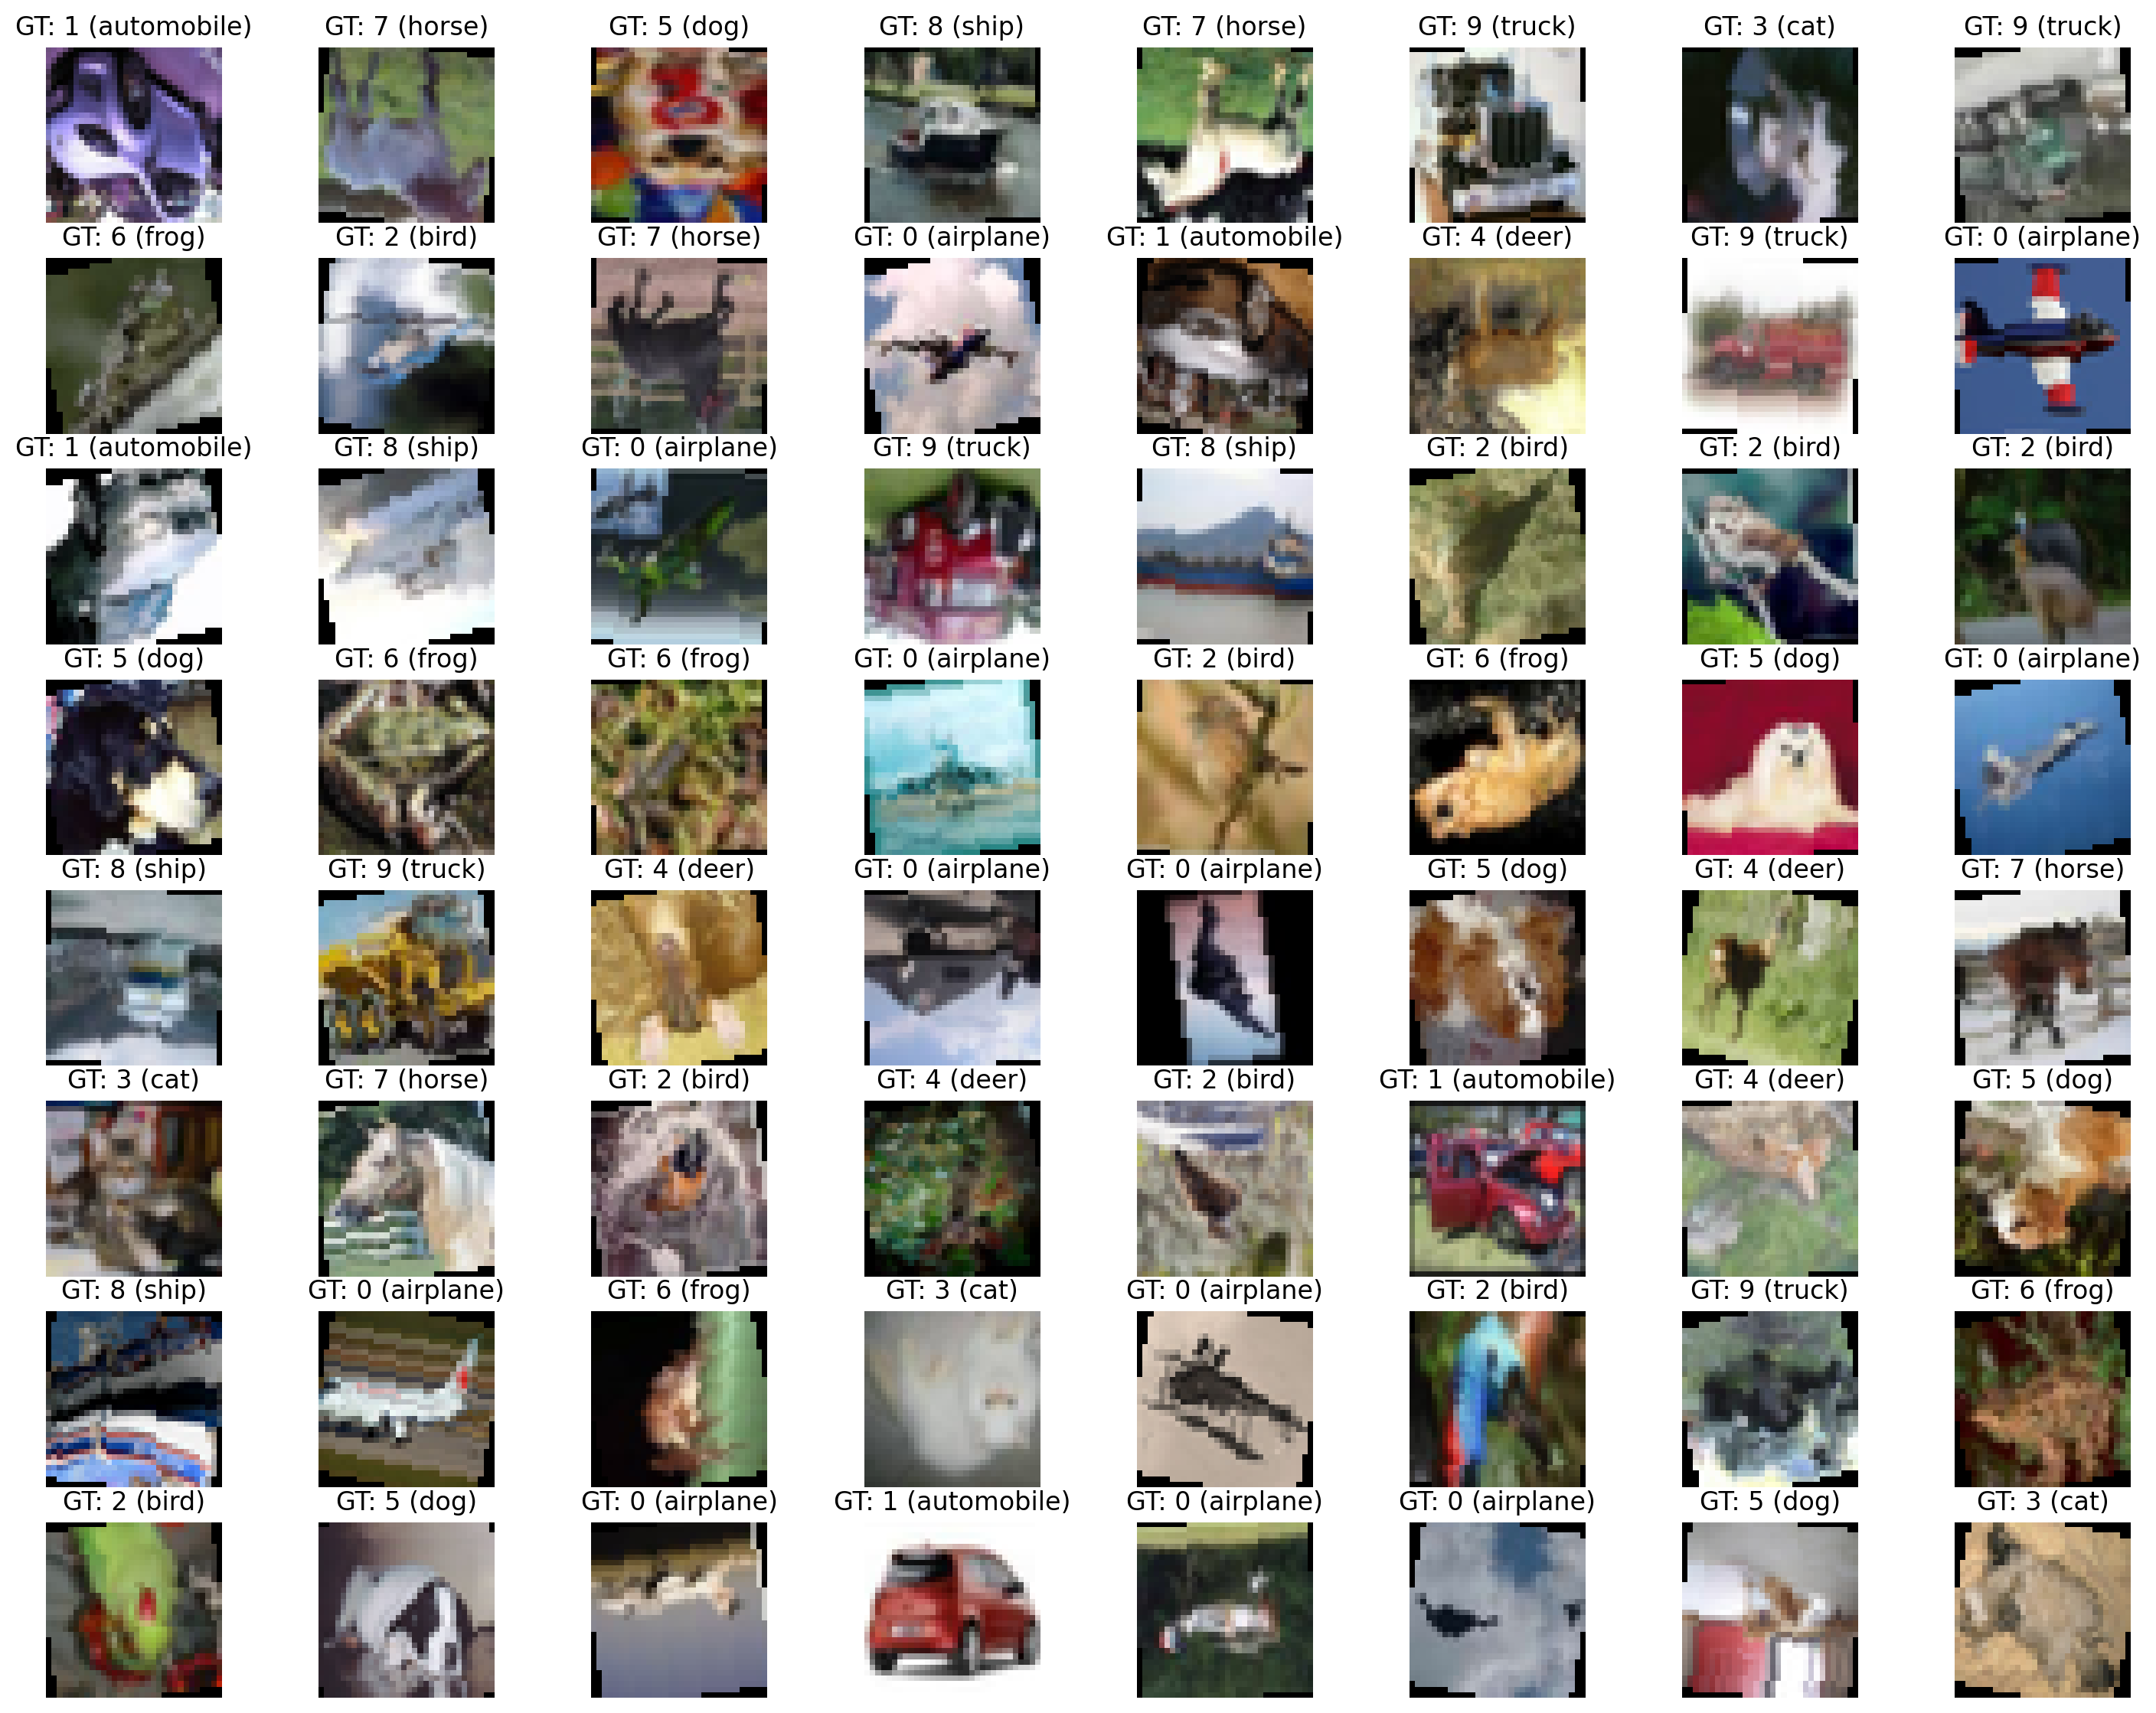

In [ ]:
indexes_to_show = np.random.choice(len(dataset_aug_train), size=64, replace=False)

plt.figure(figsize=(18, 14))
for i, index in enumerate(indexes_to_show):
    tensor, label = dataset_aug_train[index]
    image = tensor_to_image(tensor)
    plt.subplot(8, 8, i + 1)
    plt.imshow(image)
    plt.axis(False)
    plt.title(f"GT: {label} ({cifar10_class_map[label]})")
plt.show()

Посмотрим на динамику обучения с аугментациями (обратите внимание, валидационный датасет остался прежним):

In [ ]:
cnn_aug = nn.Sequential(
    CNNBlock(3, 32),
    CNNBlock(32, 64),
    CNNBlock(64, 128),
    CNNBlock(128, 256),
    CNNBlock(256, 512),
    # v NOTE THIS
    nn.AdaptiveAvgPool2d((1, 1)),  # B x 512 x 1 x 1
    # ^ NOTE THIS ^
    nn.Flatten(),  # B x 512
    nn.Linear(512, 10),
).eval()

Увеличим число эпох (забегая вперед - переобучение мы немного снизим, поэтому имеет смысл добавить итераций).

In [ ]:
dataloader_aug_train = DataLoader(
    dataset_aug_train,
    batch_size=config["batch_size"],
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=4,
)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=config["batch_size"],
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=4,
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = config["optimizer"](cnn_aug.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="seminar-05-cnn-2024",
    name="baseline_augs",
    reinit=True,
    # track hyperparameters and run metadata
    config=config,
)

epoch,▁▃▅▆█
epoch_loss_train,█▄▃▂▁
epoch_loss_val,█▂▂▂▁
loss,█▇▇▆▆▆▅▅▄▅▄▅▄▄▃▃▃▃▃▃▃▂▂▂▁▃▁▃▂▂▃▂▁▁▂▁▂▂▂▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇█████
epoch,4
epoch_loss_train,0.34519
epoch_loss_val,0.64993
loss,0.57508
lr,0.0003


In [ ]:
train_losses_aug, val_losses_aug, best_val_loss_aug, cnn_aug = run_experiment(
    cnn_aug, dataloader_aug_train, dataloader_val, loss_fn, optimizer, config["num_epochs"], device, "checkpoints_aug"
)

epoch: 000 | train: 100%|██████████| 1000/1000 [00:58<00:00, 17.10it/s]
epoch: 000 | val  : 100%|██████████| 200/200 [00:07<00:00, 27.54it/s]


New checkpoint saved to checkpoints_aug/epoch=00_valloss=1.218.pth.tar



epoch: 001 | train: 100%|██████████| 1000/1000 [01:04<00:00, 15.50it/s]
epoch: 001 | val  : 100%|██████████| 200/200 [00:03<00:00, 63.44it/s]


New checkpoint saved to checkpoints_aug/epoch=01_valloss=0.943.pth.tar



epoch: 002 | train: 100%|██████████| 1000/1000 [00:50<00:00, 19.82it/s]
epoch: 002 | val  : 100%|██████████| 200/200 [00:05<00:00, 34.35it/s]


New checkpoint saved to checkpoints_aug/epoch=02_valloss=0.885.pth.tar



epoch: 003 | train: 100%|██████████| 1000/1000 [00:58<00:00, 16.98it/s]
epoch: 003 | val  : 100%|██████████| 200/200 [00:04<00:00, 40.28it/s]


New checkpoint saved to checkpoints_aug/epoch=03_valloss=0.794.pth.tar



epoch: 004 | train: 100%|██████████| 1000/1000 [00:53<00:00, 18.86it/s]
epoch: 004 | val  : 100%|██████████| 200/200 [00:03<00:00, 65.54it/s]


New checkpoint saved to checkpoints_aug/epoch=04_valloss=0.733.pth.tar

Best val_loss = 0.733 reached at epoch 4


<ipython-input-29-db9d1f5d0be5>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(fp, map_location="cpu")


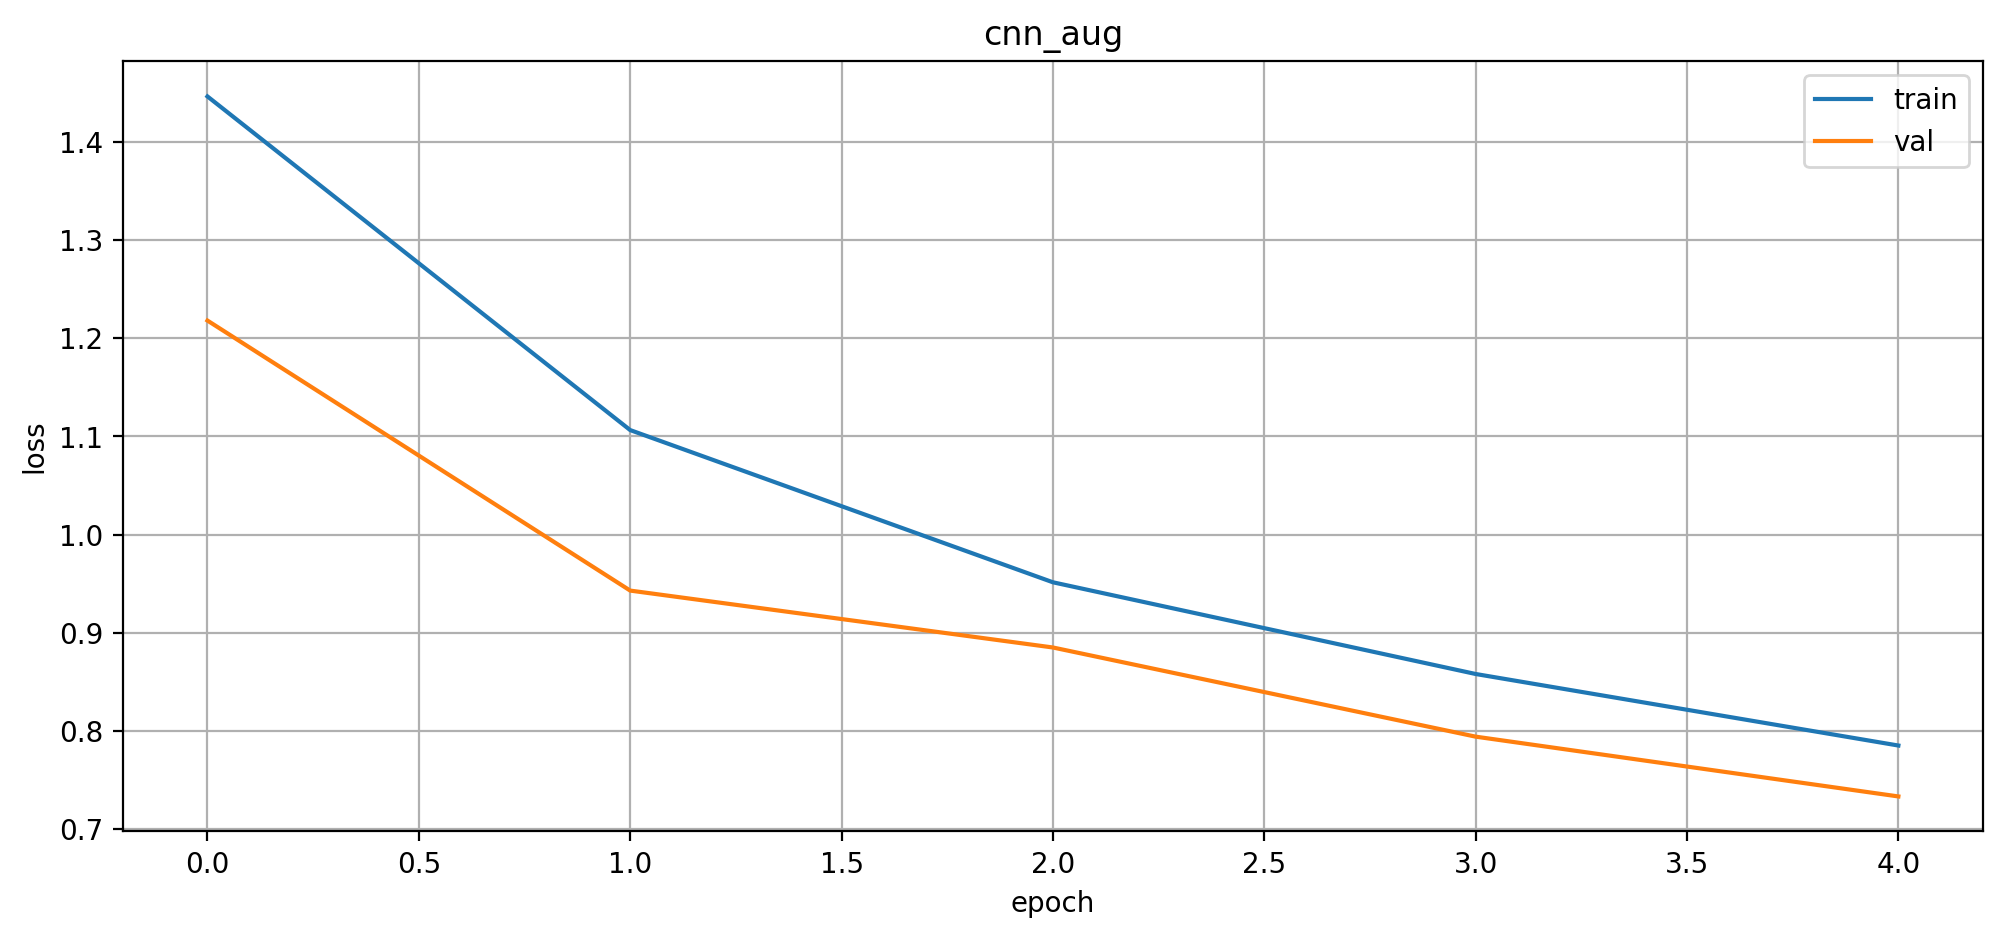

In [ ]:
plot_losses(train_losses_aug, val_losses_aug, title="cnn_aug")

In [ ]:
train_labels, train_probs, train_preds = collect_predictions(cnn_aug, dataloader_aug_train, device)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

100%|██████████| 1000/1000 [00:44<00:00, 22.51it/s]


0.74164

In [ ]:
val_labels, val_probs, val_preds = collect_predictions(cnn_aug, dataloader_val, device)

accuracy_val = accuracy_score(val_labels, val_preds)
accuracy_val

100%|██████████| 200/200 [00:03<00:00, 64.98it/s]


0.7507

По лоссам и качеству на валидации видно, что модель перестала переобучаться и требует больше итераций до сходимости. Дома обязательно добавьте в логгирование метрику качества!

## 3. Pretrained & from scratch

Важнейший прием, которым следует овладеть - это пользоваться готовыми моделями :)

Часто (*да почти всегда*) лучше учиться не со случайных весов. Если у вас в наличии есть модель, уже обученная на хоть сколько-нибудь смежном домене с целевым - надо брать и дообучаться с нее.

Откуда брать модели?
* [`torchvision.models`](https://pytorch.org/vision/0.8/models.html)
* [`timm`](https://github.com/rwightman/pytorch-image-models)
* [`transformers`](https://github.com/huggingface/transformers)
* ...

In [ ]:
from torchvision import models as M

ResNet - база. Возьмем 18-слойный:

![resnet](https://velog.velcdn.com/images%2Fe_sin528%2Fpost%2Fe272c056-3dfa-4bb6-bfc9-b309d82df932%2FResNet18.png)

In [96]:
resnet18 = M.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [97]:
import torchvision

In [98]:
torchvision.models.ResNet18_Weights.DEFAULT

ResNet18_Weights.IMAGENET1K_V1

In [99]:
resnet18.eval();

In [100]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [101]:
x = torch.randn(1, 3, 224, 224)

y = resnet18(x)
y.size()

torch.Size([1, 1000])

Как использовать готовую модель?
* Заменить выходной слой на слой с нужным числом классов
  * `timm` умеет это прямо при инициализации
* Взять `feature_extractor` модели и навернуть сверху своих слоев
  * `timm` опять же позволяет это легко сделать
  
У нас особенный случай: ResNet18 уменьшает размер входного изображения в 64 раза, а у нас картинки 32х32. Как быть?

In [102]:
x = torch.randn(1, 3, 32, 32)

y = resnet18(x)
y.size()

torch.Size([1, 1000])

Например, можно взять и выдрать слои из модели и поместить в `Sequential`, приправив своими слоями сверху:

In [103]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [104]:
cnn_finetuned = nn.Sequential(
    resnet18.conv1,
    resnet18.bn1,
    resnet18.relu,
    resnet18.maxpool,
    resnet18.layer1,
    resnet18.layer2,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(128, 10),
).eval()

In [105]:
cnn_finetuned(x)

tensor([[ 0.0239, -0.3605,  0.2512,  0.1662,  0.2582,  0.2336, -0.1801, -0.1030,
         -0.1955, -0.2192]])

Теперь про обучение. Поскольку у нас есть частично обученные веса на входе (из ResNet) и полностью необученные на выходе (свои) веса, градиенты через конец сети могут быть очень шумными. Поэтому есть практика обучения только новых голов в течение пары эпох, а затем полное обучение:

In [106]:
cnn_finetuned[0].weight.requires_grad, cnn_finetuned[-1].weight.requires_grad

(True, True)

Веса слоев можно заморозить ручками:

In [107]:
for p in cnn_finetuned.parameters():
    p.requires_grad_(False)

In [108]:
cnn_finetuned[0].weight.requires_grad, cnn_finetuned[-1].weight.requires_grad

(False, False)

In [109]:
cnn_finetuned[-1].requires_grad_(True)
cnn_finetuned[-1].weight.requires_grad

True

In [110]:
cnn_finetuned[-1]

Linear(in_features=128, out_features=10, bias=True)

In [111]:
[(n, p.requires_grad) for (n, p) in cnn_finetuned.named_parameters()]

[('0.weight', False),
 ('1.weight', False),
 ('1.bias', False),
 ('4.0.conv1.weight', False),
 ('4.0.bn1.weight', False),
 ('4.0.bn1.bias', False),
 ('4.0.conv2.weight', False),
 ('4.0.bn2.weight', False),
 ('4.0.bn2.bias', False),
 ('4.1.conv1.weight', False),
 ('4.1.bn1.weight', False),
 ('4.1.bn1.bias', False),
 ('4.1.conv2.weight', False),
 ('4.1.bn2.weight', False),
 ('4.1.bn2.bias', False),
 ('5.0.conv1.weight', False),
 ('5.0.bn1.weight', False),
 ('5.0.bn1.bias', False),
 ('5.0.conv2.weight', False),
 ('5.0.bn2.weight', False),
 ('5.0.bn2.bias', False),
 ('5.0.downsample.0.weight', False),
 ('5.0.downsample.1.weight', False),
 ('5.0.downsample.1.bias', False),
 ('5.1.conv1.weight', False),
 ('5.1.bn1.weight', False),
 ('5.1.bn1.bias', False),
 ('5.1.conv2.weight', False),
 ('5.1.bn2.weight', False),
 ('5.1.bn2.bias', False),
 ('8.weight', True),
 ('8.bias', True)]

Теперь к обучению:

In [112]:
loss_fn = nn.CrossEntropyLoss()
optimizer = config["optimizer"](
    cnn_finetuned[-1].parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"]
)

Сначала 3 эпохи учим только последний слой:

In [ ]:
wandb.finish()

epoch,▁▃▅▆█
epoch_loss_train,█▄▃▂▁
epoch_loss_val,█▄▃▂▁
loss,▇█▇▇█▅▇▇▅▄▃▄▃▅▆▄▃▂▆▂▃▃▃▅▃▂▃▃▃▁▁▃▂▃▃▃▂▂▄▄
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
epoch,4
epoch_loss_train,0.78513
epoch_loss_val,0.73327
loss,0.93829
lr,0.0003


In [113]:
wandb.init(
    # set the wandb project where this run will be logged
    project="seminar-05-cnn-2024",
    name="resnet",
    reinit=True,
    # track hyperparameters and run metadata
    config=config,
)

In [114]:
train_losses_finetuned, val_losses_finetuned, best_val_loss_finetuned, cnn_finetuned = run_experiment(
    cnn_finetuned, dataloader_aug_train, dataloader_val, loss_fn, optimizer, 3, device, "checkpoints_finetuned"
)

epoch: 000 | train: 100%|██████████| 1000/1000 [00:46<00:00, 21.67it/s]
epoch: 000 | val  : 100%|██████████| 200/200 [00:02<00:00, 67.00it/s]


New checkpoint saved to checkpoints_finetuned/epoch=00_valloss=2.070.pth.tar



epoch: 001 | train: 100%|██████████| 1000/1000 [00:47<00:00, 20.98it/s]
epoch: 001 | val  : 100%|██████████| 200/200 [00:03<00:00, 62.98it/s]


New checkpoint saved to checkpoints_finetuned/epoch=01_valloss=1.910.pth.tar



epoch: 002 | train: 100%|██████████| 1000/1000 [00:45<00:00, 21.93it/s]
epoch: 002 | val  : 100%|██████████| 200/200 [00:03<00:00, 59.73it/s]

New checkpoint saved to checkpoints_finetuned/epoch=02_valloss=1.789.pth.tar

Best val_loss = 1.789 reached at epoch 2



<ipython-input-29-db9d1f5d0be5>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(fp, map_location="cpu")


Теперь размораживаем всю сеть и учим целиком:

In [115]:
for p in cnn_finetuned.parameters():
    p.requires_grad_(True)


optimizer = config["optimizer"](
    cnn_finetuned.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"]
)

In [118]:
train_losses_finetuned, val_losses_finetuned, best_val_loss_finetuned, cnn_finetuned = run_experiment(
    cnn_finetuned,
    dataloader_aug_train,
    dataloader_val,
    loss_fn,
    optimizer,
    config["num_epochs"],
    device,
    "checkpoints_finetuned",
    start_epoch=3,
)

epoch: 003 | train: 100%|██████████| 1000/1000 [00:47<00:00, 21.27it/s]
epoch: 003 | val  : 100%|██████████| 200/200 [00:02<00:00, 68.77it/s]


New checkpoint saved to checkpoints_finetuned/epoch=03_valloss=0.814.pth.tar



epoch: 004 | train: 100%|██████████| 1000/1000 [00:47<00:00, 20.95it/s]
epoch: 004 | val  : 100%|██████████| 200/200 [00:02<00:00, 70.55it/s]

New checkpoint saved to checkpoints_finetuned/epoch=04_valloss=0.737.pth.tar

Best val_loss = 0.737 reached at epoch 4



<ipython-input-29-db9d1f5d0be5>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(fp, map_location="cpu")


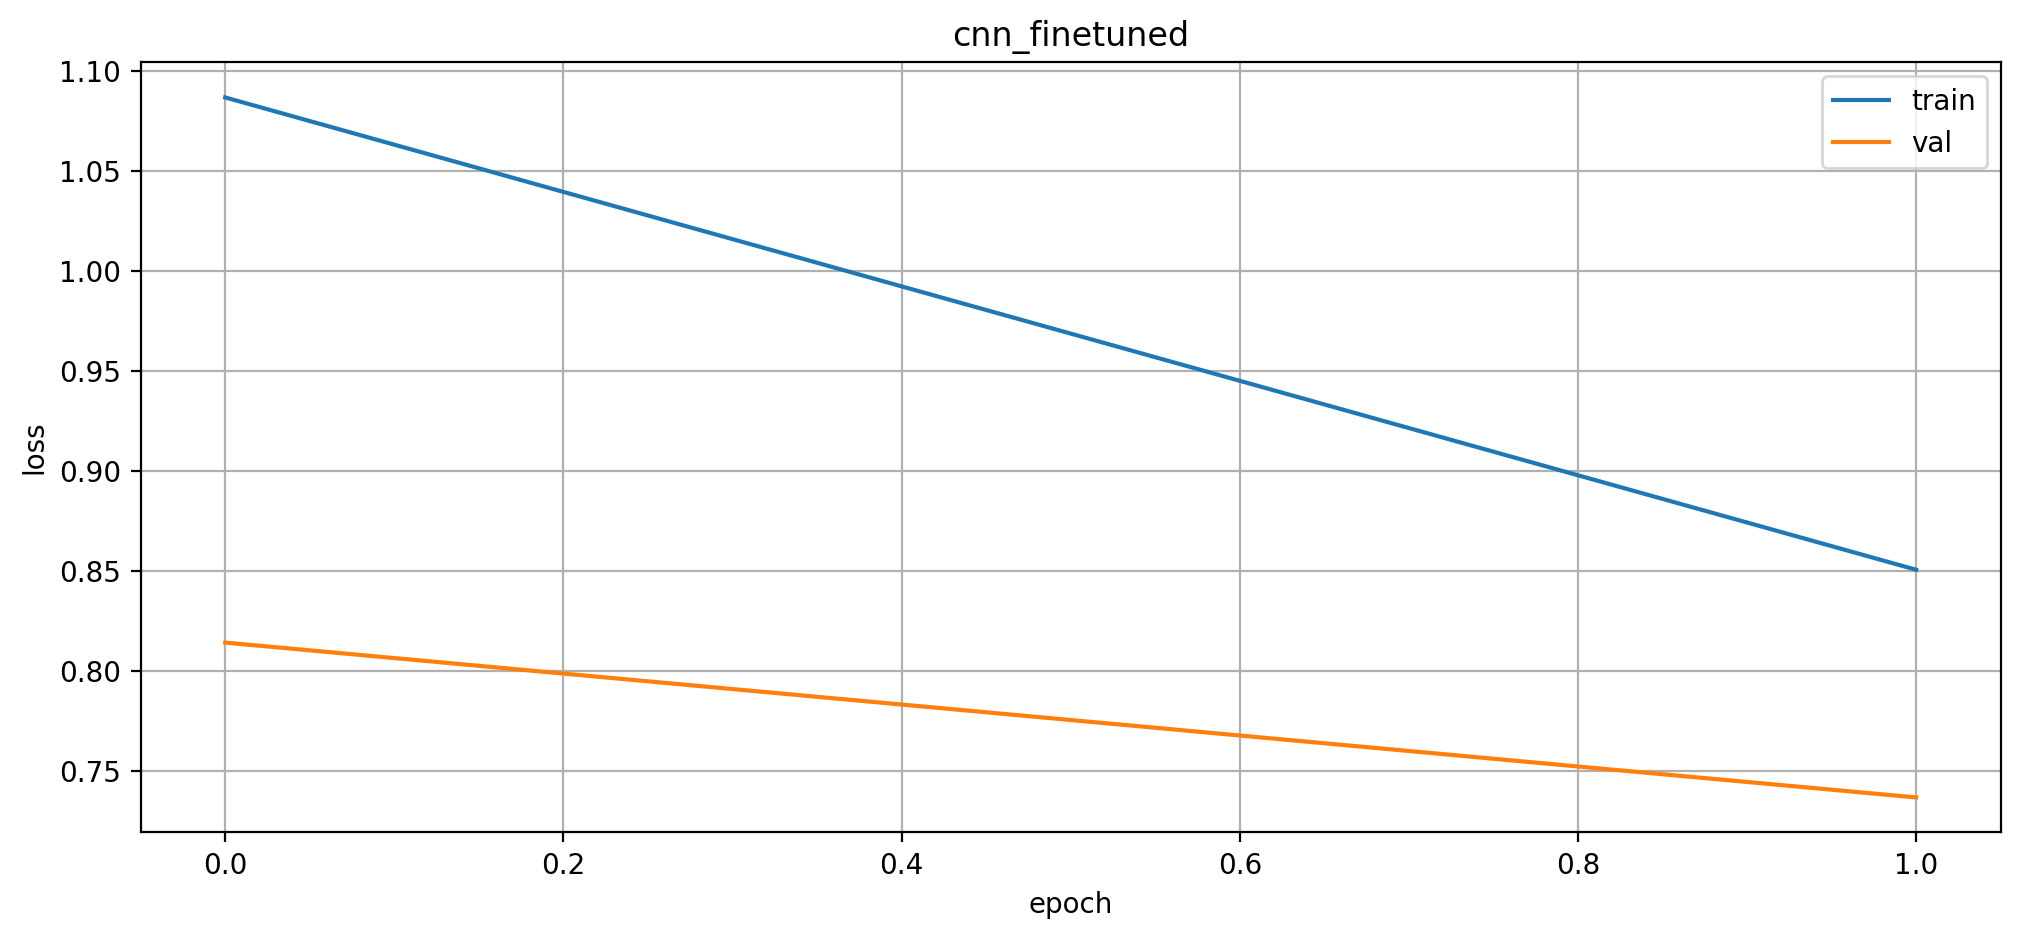

In [119]:
plot_losses(train_losses_finetuned, val_losses_finetuned, title="cnn_finetuned")

In [120]:
train_labels, train_probs, train_preds = collect_predictions(cnn_finetuned, dataloader_aug_train, device)

accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_train

100%|██████████| 1000/1000 [00:41<00:00, 24.29it/s]


0.72892

In [121]:
val_labels, val_probs, val_preds = collect_predictions(cnn_finetuned, dataloader_val, device)

accuracy_val = accuracy_score(val_labels, val_preds)
accuracy_val

100%|██████████| 200/200 [00:02<00:00, 69.20it/s]


0.7442

In [122]:
wandb.finish()

epoch,▁▃▅▆█
epoch_loss_train,█▇▆▂▁
epoch_loss_val,█▇▇▁▁
loss,████████▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▆▆▅▃▃▃▄▃▂▂▄▃▃▂▂▁▂
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
epoch,4
epoch_loss_train,0.85044
epoch_loss_val,0.73654
loss,0.71479
lr,0.0003


## 4. LR scheduling

Последняя на сегодня - работа с LR.
Из лекций вы могли запомнить, что варьирование LR при обучении (даже адаптивных методов) может достичь более высокого качества.

![lrs](https://i.stack.imgur.com/UHYMw.png)

`pytorch` предоставляет возможности и для этого.

### 4.1. Обновление по сигналу от метрик (ReduceLROnPlateau)

Можно изменять LR, основываясь на изменении целевой метрики.
Если, например, лосс давно не падает, можно уменьшить LR:

In [123]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [124]:
cnn_aug = nn.Sequential(
    CNNBlock(3, 32), CNNBlock(32, 64), CNNBlock(64, 128), nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(128, 10)
)

In [125]:
loss_fn = nn.CrossEntropyLoss()
config["learning_rate"] = 1.5

optimizer = torch.optim.Adam(cnn_aug.parameters(), lr=config["learning_rate"])

scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=1, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [126]:
wandb.init(
    # set the wandb project where this run will be logged
    project="seminar-05-cnn-2024",
    name="lr_reduce",
    reinit=True,
    # track hyperparameters and run metadata
    config=config,
)

In [129]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, epoch, device):
    # v NOTE THIS v
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()
    # ^ NOTE THIS ^

    model = model.to(device)
    num_steps = len(dataloader)
    losses = []
    for i, batch in enumerate(tqdm.tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}")):
        xs, ys_true = batch

        ys_pred = model(xs.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        if stage == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # логгируем номер шага при обучении
            wandb.log({
                "training_step": i + num_steps * epoch,
                "lr": optimizer.param_groups[0]["lr"],
                "loss": loss,
            })

        losses.append(loss.detach().cpu().item())

    if stage != "train":
        scheduler.step(np.mean(losses))

    return np.mean(losses)

In [130]:
train_losses_aug, val_losses_aug, best_val_loss_aug, cnn_aug = run_experiment(
    cnn_aug, dataloader_aug_train, dataloader_val, loss_fn, optimizer, config["num_epochs"], device, "checkpoints_aug"
)

epoch: 000 | train: 100%|██████████| 1000/1000 [00:47<00:00, 21.06it/s]
epoch: 000 | val  : 100%|██████████| 200/200 [00:04<00:00, 45.92it/s]


New checkpoint saved to checkpoints_aug/epoch=00_valloss=2.397.pth.tar



epoch: 001 | train: 100%|██████████| 1000/1000 [00:46<00:00, 21.57it/s]
epoch: 001 | val  : 100%|██████████| 200/200 [00:02<00:00, 70.15it/s]
epoch: 002 | train: 100%|██████████| 1000/1000 [00:46<00:00, 21.45it/s]
epoch: 002 | val  : 100%|██████████| 200/200 [00:03<00:00, 61.96it/s]
epoch: 003 | train: 100%|██████████| 1000/1000 [00:47<00:00, 21.18it/s]
epoch: 003 | val  : 100%|██████████| 200/200 [00:02<00:00, 71.37it/s]


New checkpoint saved to checkpoints_aug/epoch=03_valloss=2.319.pth.tar



epoch: 004 | train: 100%|██████████| 1000/1000 [00:56<00:00, 17.58it/s]
epoch: 004 | val  : 100%|██████████| 200/200 [00:05<00:00, 35.18it/s]

Best val_loss = 2.319 reached at epoch 3



<ipython-input-29-db9d1f5d0be5>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(fp, map_location="cpu")


In [131]:
wandb.finish()

epoch,▁▃▅▆█
epoch_loss_train,▇█▇▁▁
epoch_loss_val,▆▇█▁▁
loss,▃▂▃▅▄▂▄█▄▄▁▃▂▃▂▅▃▁▅▄█▄▃▆▃▂▁▂▁▁▂▁▂▂▂▂▂▂▂▃
lr,███████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_step,▁▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇█
epoch,4
epoch_loss_train,2.31637
epoch_loss_val,2.32345
loss,2.27585
lr,0.15


### 4.2. Обновление каждую эпоху (StepLR)

In [132]:
from torch.optim.lr_scheduler import StepLR

In [133]:
cnn_aug = nn.Sequential(
    CNNBlock(3, 32), CNNBlock(32, 64), CNNBlock(64, 128), nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(128, 10)
)

In [134]:
loss_fn = nn.CrossEntropyLoss()
config["learning_rate"] = 3e-4
config["num_epochs"] = 5

optimizer = torch.optim.Adam(cnn_aug.parameters(), lr=config["learning_rate"])

scheduler = StepLR(optimizer, step_size=1, gamma=0.1, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [135]:
wandb.init(
    # set the wandb project where this run will be logged
    project="seminar-05-cnn-2024",
    name="lr_step",
    reinit=True,
    # track hyperparameters and run metadata
    config=config,
)

In [136]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, epoch, device):
    # v NOTE THIS v
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()
    # ^ NOTE THIS ^

    model = model.to(device)
    num_steps = len(dataloader)
    losses = []
    for i, batch in enumerate(tqdm.tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}")):
        xs, ys_true = batch

        ys_pred = model(xs.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        if stage == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # логгируем номер шага при обучении
            wandb.log({
                "training_step": i + num_steps * epoch,
                "lr": optimizer.param_groups[0]["lr"],
                "loss": loss,
            })

        losses.append(loss.detach().cpu().item())

    if stage != "train":
        scheduler.step()

    return np.mean(losses)

In [137]:
train_losses_aug, val_losses_aug, best_val_loss_aug, cnn_aug = run_experiment(
    cnn_aug, dataloader_aug_train, dataloader_val, loss_fn, optimizer, config["num_epochs"], device, "checkpoints_aug"
)

epoch: 000 | train: 100%|██████████| 1000/1000 [00:57<00:00, 17.38it/s]
epoch: 000 | val  : 100%|██████████| 200/200 [00:02<00:00, 72.39it/s]


New checkpoint saved to checkpoints_aug/epoch=00_valloss=1.254.pth.tar



epoch: 001 | train: 100%|██████████| 1000/1000 [00:50<00:00, 19.79it/s]
epoch: 001 | val  : 100%|██████████| 200/200 [00:04<00:00, 42.48it/s]


New checkpoint saved to checkpoints_aug/epoch=01_valloss=1.058.pth.tar



epoch: 002 | train: 100%|██████████| 1000/1000 [00:46<00:00, 21.49it/s]
epoch: 002 | val  : 100%|██████████| 200/200 [00:04<00:00, 40.59it/s]


New checkpoint saved to checkpoints_aug/epoch=02_valloss=1.052.pth.tar



epoch: 003 | train: 100%|██████████| 1000/1000 [00:46<00:00, 21.62it/s]
epoch: 003 | val  : 100%|██████████| 200/200 [00:02<00:00, 73.24it/s]


New checkpoint saved to checkpoints_aug/epoch=03_valloss=1.050.pth.tar



epoch: 004 | train: 100%|██████████| 1000/1000 [00:47<00:00, 20.90it/s]
epoch: 004 | val  : 100%|██████████| 200/200 [00:02<00:00, 72.88it/s]

Best val_loss = 1.050 reached at epoch 3



<ipython-input-29-db9d1f5d0be5>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(fp, map_location="cpu")


In [138]:
wandb.finish()

epoch,▁▃▅▆█
epoch_loss_train,█▂▁▁▁
epoch_loss_val,█▁▁▁▁
loss,██▇▅▅▅▅▁▃▃▂▂▃▃▂▄▃▂▃▂▂▂▁▁▂▄▃▂▂▃▂▃▁▃▃▃▃▄▂▃
lr,███████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
epoch,4
epoch_loss_train,1.10416
epoch_loss_val,1.05209
loss,1.24406
lr,0.0


### 4.3. Обновление каждую итерацию (CosineAnnealingLR)

Есть разные техники изменения LR по заданному закону.
Например, [CosineAnnealing](https://paperswithcode.com/method/cosine-annealing).

In [139]:
from torch.optim.lr_scheduler import CosineAnnealingLR

In [140]:
cnn_aug = nn.Sequential(
    CNNBlock(3, 32), CNNBlock(32, 64), CNNBlock(64, 128), nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(128, 10)
)

In [141]:
loss_fn = nn.CrossEntropyLoss()
config["learning_rate"] = 3e-4
config["num_epochs"] = 5

optimizer = torch.optim.Adam(cnn_aug.parameters(), lr=config["learning_rate"])

scheduler = CosineAnnealingLR(optimizer, T_max=int(len(dataloader_aug_train)) * config["num_epochs"])

In [142]:
wandb.init(
    # set the wandb project where this run will be logged
    project="seminar-05-cnn-2024",
    name="lr_cosine",
    reinit=True,
    # track hyperparameters and run metadata
    config=config,
)

In [143]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, epoch, device):
    # v NOTE THIS v
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()
    # ^ NOTE THIS ^

    model = model.to(device)
    num_steps = len(dataloader)
    losses = []
    for i, batch in enumerate(tqdm.tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}")):
        xs, ys_true = batch

        ys_pred = model(xs.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        if stage == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # логгируем номер шага при обучении
            wandb.log({
                "training_step": i + num_steps * epoch,
                "lr": optimizer.param_groups[0]["lr"],
                "loss": loss,
            })
            # вызываем после каждого шага оптимизации
            scheduler.step()

        losses.append(loss.detach().cpu().item())

    return np.mean(losses)

In [144]:
train_losses_aug, val_losses_aug, best_val_loss_aug, cnn_aug = run_experiment(
    cnn_aug, dataloader_aug_train, dataloader_val, loss_fn, optimizer, config["num_epochs"], device, "checkpoints_aug"
)

epoch: 000 | train: 100%|██████████| 1000/1000 [00:46<00:00, 21.50it/s]
epoch: 000 | val  : 100%|██████████| 200/200 [00:02<00:00, 72.42it/s]


New checkpoint saved to checkpoints_aug/epoch=00_valloss=1.163.pth.tar



epoch: 001 | train: 100%|██████████| 1000/1000 [00:46<00:00, 21.31it/s]
epoch: 001 | val  : 100%|██████████| 200/200 [00:02<00:00, 72.03it/s]


New checkpoint saved to checkpoints_aug/epoch=01_valloss=1.001.pth.tar



epoch: 002 | train: 100%|██████████| 1000/1000 [00:45<00:00, 21.83it/s]
epoch: 002 | val  : 100%|██████████| 200/200 [00:02<00:00, 71.06it/s]


New checkpoint saved to checkpoints_aug/epoch=02_valloss=0.894.pth.tar



epoch: 003 | train: 100%|██████████| 1000/1000 [00:45<00:00, 22.17it/s]
epoch: 003 | val  : 100%|██████████| 200/200 [00:02<00:00, 73.86it/s]


New checkpoint saved to checkpoints_aug/epoch=03_valloss=0.841.pth.tar



epoch: 004 | train: 100%|██████████| 1000/1000 [00:47<00:00, 20.91it/s]
epoch: 004 | val  : 100%|██████████| 200/200 [00:02<00:00, 73.89it/s]

New checkpoint saved to checkpoints_aug/epoch=04_valloss=0.825.pth.tar

Best val_loss = 0.825 reached at epoch 4



<ipython-input-29-db9d1f5d0be5>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(fp, map_location="cpu")


In [145]:
wandb.finish()

epoch,▁▃▅▆█
epoch_loss_train,█▄▃▁▁
epoch_loss_val,█▅▂▁▁
loss,█▇▇▇█▆▆▅▃▄▄▄▄▂▃▄▆▂▄▃▃▄▃▂▄▃▂▄▄▄▂▁▅▂▅▄▂▂▃▄
lr,██████████▇▇▇▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁
training_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇█████
epoch,4
epoch_loss_train,0.88455
epoch_loss_val,0.82466
loss,0.77172
lr,0.0


## Итоги

* Научились добавлять аугментации к обучению
* Познакомились с методом использования предобученных моделей
* Посмотрели на работу с LR scheduling в pytorch.

Рекомендуется (в который раз) почитать пост от любимого нашего Andrej Karpathy [A Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/) и обзорную статью (не самую новую, но все же) по трюкам для обучения моделей [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/pdf/1812.01187v2.pdf), а также поглядывать при планировании экспериментов в [гайд от Google](https://github.com/google-research/tuning_playbook).

Впереди ждет соревнование по классификации картинок на Kaggle, где вы сможете применить все полученные (и неполученные %)) знания на практике!